In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [16]:
#  imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageOnlyDataset
from src.models import build_vision_backbone
from src.train import train_one_epoch_image, validate_image

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp2")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp2"]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
#  KFold CV training
backbone_name = cfg["backbone"] # tf_efficientnet_B0
img_size = cfg["img_size"] # 256
aug_type = cfg["aug"]   # lite
loss_name = cfg["loss"] # mse

n_splits = cfg["n_splits"]
epochs = cfg["epochs"]
batch_size = cfg["batch_size"]
lr = cfg["lr"]
weight_decay = cfg["weight_decay"]
patience = cfg["patience"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
fold_rmse = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n=== {cfg['name']}: Fold {fold+1} ===")

    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_tf = build_transforms(img_size, aug_type, train=True)
    val_tf = build_transforms(img_size, aug_type, train=False)

    train_ds = ImageOnlyDataset(train_df, img_folder, train_tf)
    val_ds = ImageOnlyDataset(val_df, img_folder, val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=4)

    model = build_vision_backbone(
        backbone_name, img_size, mode="regression"
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if loss_name == "bce":
        criterion = torch.nn.BCEWithLogitsLoss()
        scale_target = True
    else:
        criterion = torch.nn.MSELoss()
        scale_target = False

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    best_rmse = 1e10
    best_state = None
    epochs_no_improve = 0
    train_losses, val_rmses = [], []

    for epoch in range(epochs):
        avg_train_loss = train_one_epoch_image(
            model, train_loader, optimizer, criterion, device, scale_target
        )
        scheduler.step()

        rmse, val_preds, val_targets = validate_image(
            model, val_loader, device, scale_target
        )
        train_losses.append(avg_train_loss)
        val_rmses.append(rmse)

        print(f"Epoch {epoch+1}/{epochs} | Fold {fold+1} "
              f"TrainLoss: {avg_train_loss:.4f} ValRMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    hist_df = pd.DataFrame({
        "epoch": range(1, len(train_losses)+1),
        "train_loss": train_losses,
        "val_rmse": val_rmses,
    })
    hist_df.to_csv(os.path.join(out_dir, f"history_fold{fold+1}.csv"),
                   index=False)

    model.load_state_dict(best_state)
    _, val_preds, _ = validate_image(
        model, val_loader, device, scale_target
    )
    oof_pred[val_idx] = val_preds
    fold_rmse.append(best_rmse)
    print(f"Fold {fold+1} best RMSE: {best_rmse:.4f}")

    torch.save(best_state,
               os.path.join(out_dir, f"model_fold{fold+1}.pt"))

oof_rmse = root_mean_squared_error(df["Pawpularity"], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df["Pawpularity"],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp2_EffNetB0_256_Lite: Fold 1 ===
Epoch 1/10 | Fold 1 TrainLoss: 694.2997 ValRMSE: 20.6600
Epoch 2/10 | Fold 1 TrainLoss: 352.2048 ValRMSE: 20.0162
Epoch 3/10 | Fold 1 TrainLoss: 309.4517 ValRMSE: 19.8294
Epoch 4/10 | Fold 1 TrainLoss: 277.3407 ValRMSE: 19.7865
Epoch 5/10 | Fold 1 TrainLoss: 250.9935 ValRMSE: 19.8741
Epoch 6/10 | Fold 1 TrainLoss: 231.8436 ValRMSE: 19.8835
Epoch 7/10 | Fold 1 TrainLoss: 212.4786 ValRMSE: 19.9675
Epoch 8/10 | Fold 1 TrainLoss: 199.6061 ValRMSE: 20.0803
Epoch 9/10 | Fold 1 TrainLoss: 195.2268 ValRMSE: 20.0313
Early stopping at epoch 9
Fold 1 best RMSE: 19.7865

=== Exp2_EffNetB0_256_Lite: Fold 2 ===
Epoch 1/10 | Fold 2 TrainLoss: 748.5125 ValRMSE: 19.5017
Epoch 2/10 | Fold 2 TrainLoss: 354.1806 ValRMSE: 19.0227
Epoch 3/10 | Fold 2 TrainLoss: 312.1650 ValRMSE: 18.8599
Epoch 4/10 | Fold 2 TrainLoss: 282.0745 ValRMSE: 18.9095
Epoch 5/10 | Fold 2 TrainLoss: 257.3652 ValRMSE: 18.9171
Epoch 6/10 | Fold 2 TrainLoss: 237.2122 ValRMSE: 19.0439
Epoch 7/10 | 

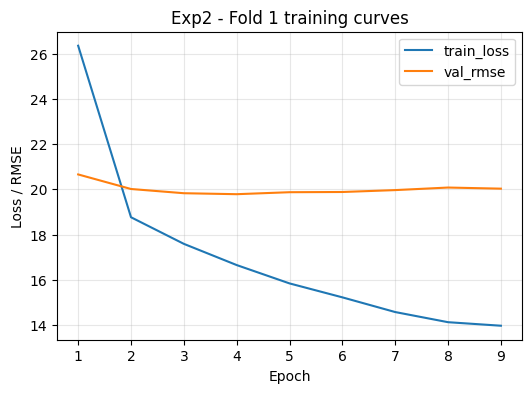

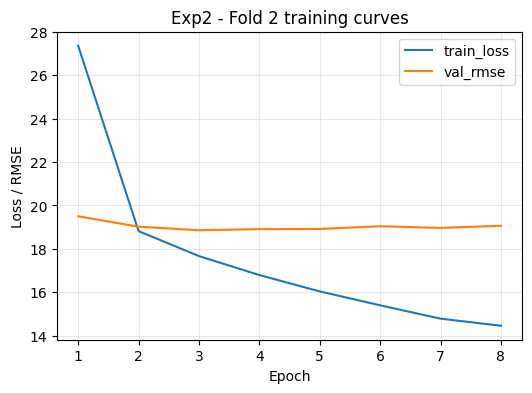

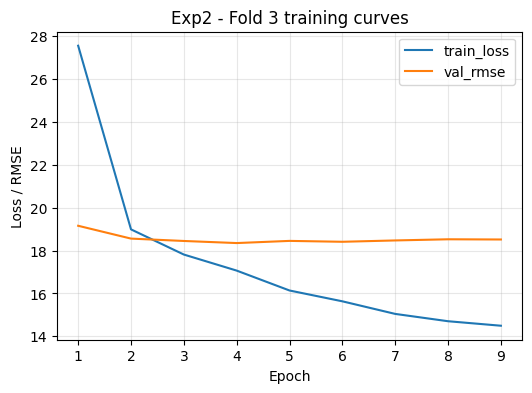

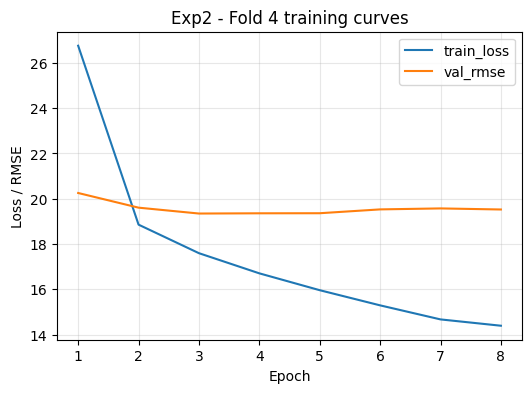

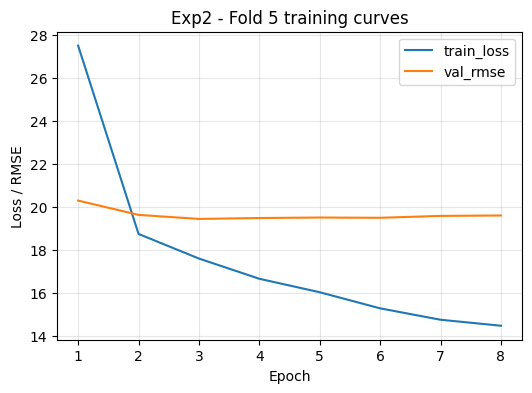

In [18]:
#  Plot curves for a couple of folds
for fold in [1, 2, 3, 4, 5]:
    hist_path = os.path.join(out_dir, f"history_fold{fold}.csv")
    if not os.path.exists(hist_path):
        continue
    hist = pd.read_csv(hist_path)

    plt.figure(figsize=(6,4))
    plt.plot(hist["epoch"], np.sqrt(hist["train_loss"]), label="train_loss")
    plt.plot(hist["epoch"], hist["val_rmse"], label="val_rmse")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / RMSE")
    plt.title(f"Exp2 - Fold {fold} training curves")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [19]:
# Worst error images 
errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()


,Id,ytrue,oof_pred,abs_err
0,73f9e8a6d0926f7c5201f034406d986d,100,13.145608,86.854392
1,3d69187b44aba9adbd7fd5f0d3554cd1,7,89.388916,82.388916
2,b2a389311b683a90c3c9763540a86bab,2,79.910835,77.910835
3,1e93d87f931fc6069fb37ccb79ac68c4,2,79.362770,77.362770
4,3d946559e2b4b210a06e9103b0dd72e9,5,82.070969,77.070969


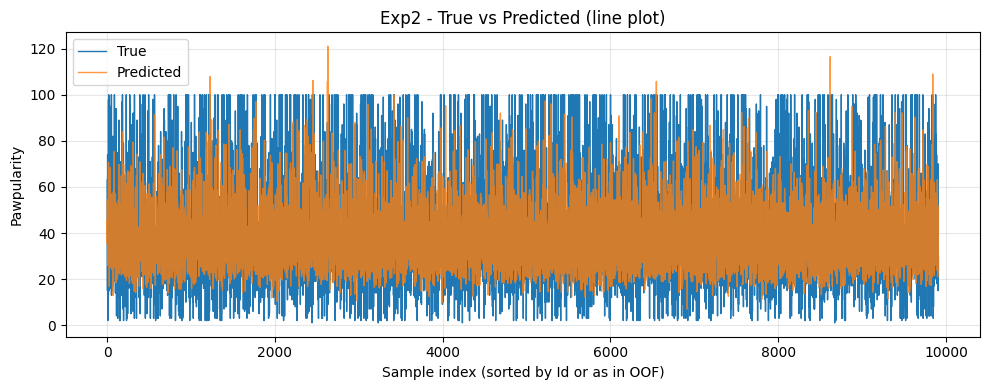

In [20]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_error_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp2")





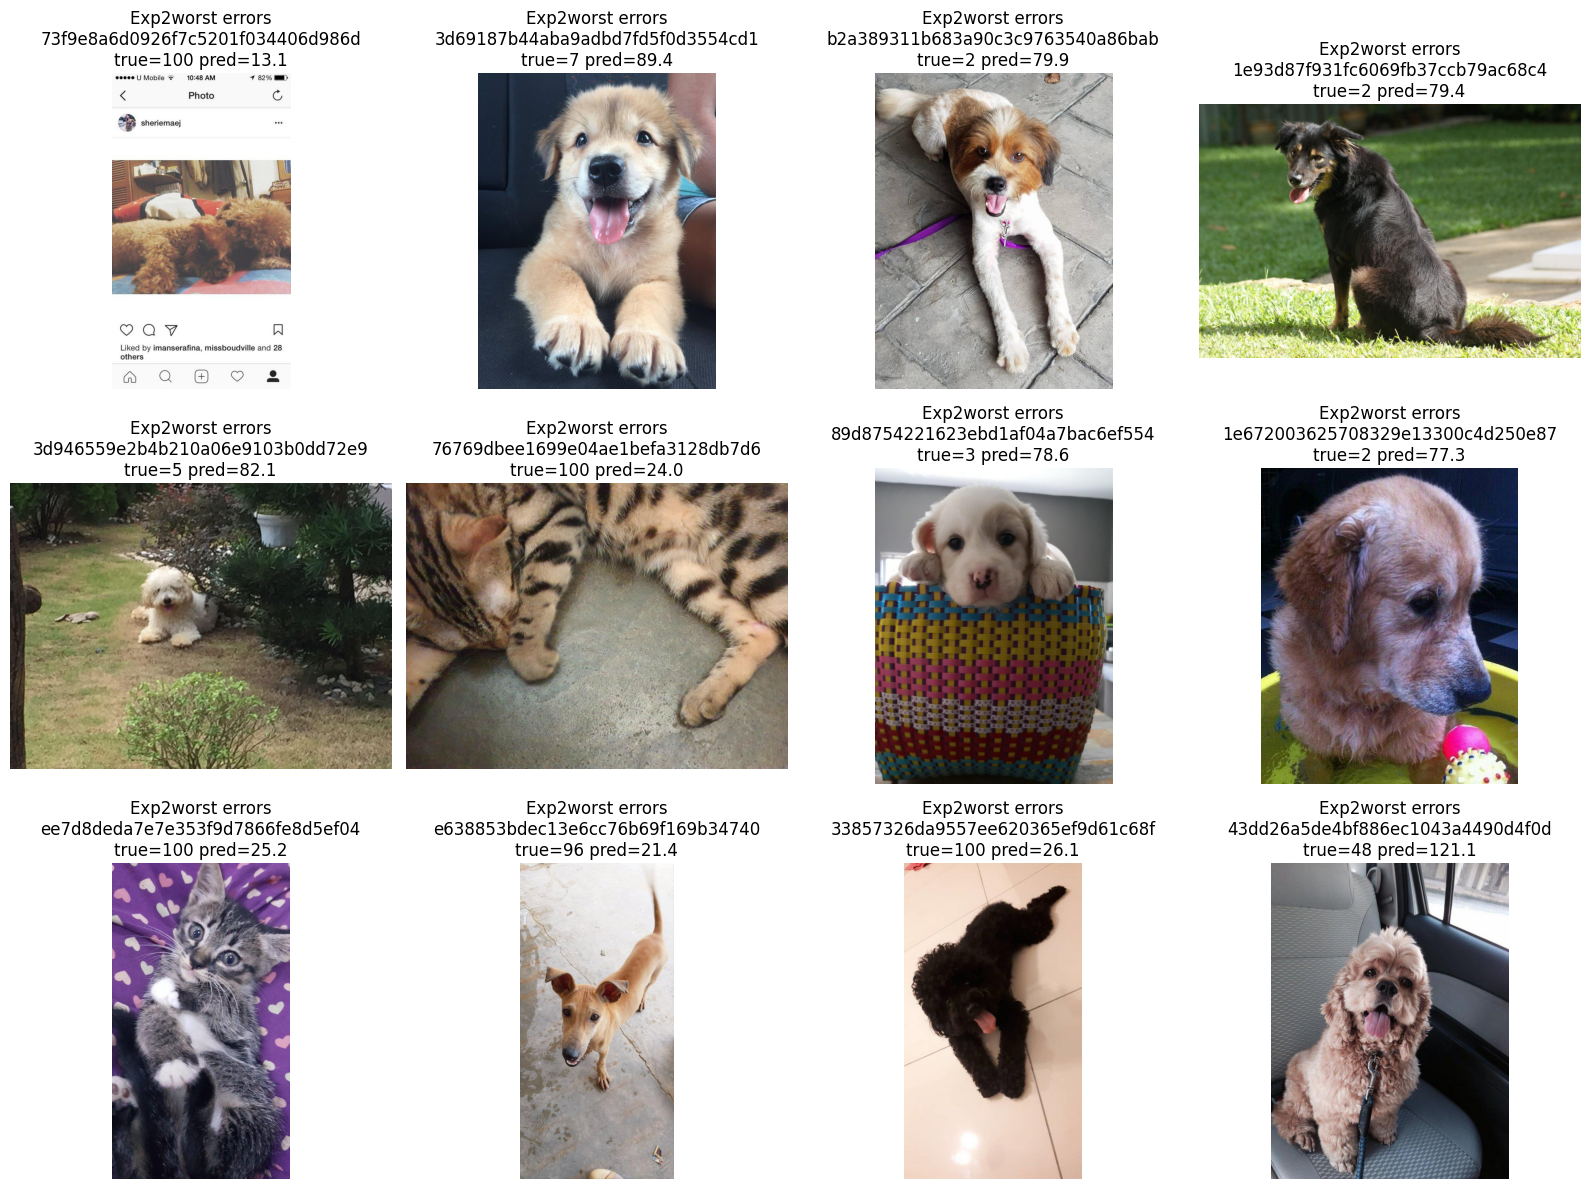

In [21]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_error_images_grid(err_df, img_folder, n=12, title_prefix="Exp2worst errors")